In [22]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T
from sklearn.metrics import accuracy_score, f1_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch.utils.data import random_split


In [15]:
labels_dir="C:\\Users\\ASUS\\Desktop\\D\\ISBI2016_ISIC_Part3_Training_GroundTruth.csv"
images_dir="C:\\Users\\ASUS\\Desktop\\D\\ISBI2016_ISIC_Part3_Training_Data"

In [4]:
raw_df=pd.read_csv(labels_dir,header=None,names=['image_id','diagnosis'])

In [5]:
raw_df

,image_id,diagnosis
0,ISIC_0000000,benign
1,ISIC_0000001,benign
2,ISIC_0000002,malignant
3,ISIC_0000004,malignant
4,ISIC_0000006,benign
...,...,...
895,ISIC_0011393,benign
896,ISIC_0011397,benign
897,ISIC_0011398,benign
898,ISIC_0011400,benign


In [6]:
label_map={'benign':0 , 'malignant':1}
raw_df['label']=raw_df['diagnosis'].map(label_map)

In [7]:
raw_df.head(10)

,image_id,diagnosis,label
0,ISIC_0000000,benign,0
1,ISIC_0000001,benign,0
2,ISIC_0000002,malignant,1
3,ISIC_0000004,malignant,1
4,ISIC_0000006,benign,0
5,ISIC_0000007,benign,0
6,ISIC_0000008,benign,0
7,ISIC_0000009,benign,0
8,ISIC_0000010,benign,0
9,ISIC_0000011,benign,0


In [8]:
df = raw_df[["image_id", "label"]]

In [9]:
df.to_csv('labels.csv',index=False)

In [13]:
transform=T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [14]:
class ISICDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None):
        self.df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = row["image_id"]
        label = int(row["label"])
        img_path = os.path.join(self.img_dir, img_id + ".jpg")
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label


In [16]:
dataset=ISICDataset('labels.csv',images_dir,transform)

In [18]:
img,lb=dataset[9]

In [19]:
img.shape

torch.Size([3, 224, 224])

In [21]:
lb

0

In [23]:
train_size=int(0.8*len(dataset))
test_size = len(dataset) - train_size
train_ds, test_ds = random_split(dataset,[train_size, test_size])

In [24]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

In [26]:
len(train_ds)

720

In [27]:
torch.cuda.is_available()

True

In [28]:
device='cuda'

In [29]:
class DinoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")
        self.backbone.eval()              
        self.backbone.requires_grad_(False)  # no gradients

    def forward(self, x):
        with torch.no_grad():             
            feats = self.backbone(x)      
        return feats


In [31]:
encoder= DinoEncoder().to(device)


Using cache found in C:\Users\ASUS/.cache\torch\hub\facebookresearch_dinov2_main
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to C:\Users\ASUS/.cache\torch\hub\checkpoints\dinov2_vits14_pretrain.pth
100.0%


In [32]:
class LinearProbe(nn.Module):
    def __init__(self, embed_dim=384, num_classes=2):
        super().__init__()
        self.fc = nn.Linear(embed_dim, num_classes)
    def forward(self, x):
        return self.fc(x)


In [33]:
classifier = LinearProbe().to(device)

In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)

In [35]:
num_epochs =15
for epoch in range(num_epochs):
    classifier.train()
    epoch_losses = []

    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        feats = encoder(imgs)              
        logits = classifier(feats)         
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {np.mean(epoch_losses):.4f}")


Epoch 1/15 - Loss: 0.8323
Epoch 2/15 - Loss: 0.4747
Epoch 3/15 - Loss: 0.4279
Epoch 4/15 - Loss: 0.3847
Epoch 5/15 - Loss: 0.3680
Epoch 6/15 - Loss: 0.3619
Epoch 7/15 - Loss: 0.3435
Epoch 8/15 - Loss: 0.3332
Epoch 9/15 - Loss: 0.3290
Epoch 10/15 - Loss: 0.3156
Epoch 11/15 - Loss: 0.3175
Epoch 12/15 - Loss: 0.3007
Epoch 13/15 - Loss: 0.2912
Epoch 14/15 - Loss: 0.2852
Epoch 15/15 - Loss: 0.2981


In [38]:
classifier.eval()
y_true, y_pred = [],[]

In [39]:
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        feats = encoder(imgs)
        logits = classifier(feats)
        preds = torch.argmax(logits, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.8333
F1-score: 0.5161


In [40]:
all_feats = []
all_labels = []

In [41]:
encoder.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        feats = encoder(imgs).cpu().numpy()
        all_feats.append(feats)
        all_labels.extend(labels.numpy())

all_feats = np.concatenate(all_feats, axis=0)
all_labels = np.array(all_labels)
all_feats.shape, all_labels.shape


((180, 384), (180,))

In [42]:
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30)
feats_2d = tsne.fit_transform(all_feats)

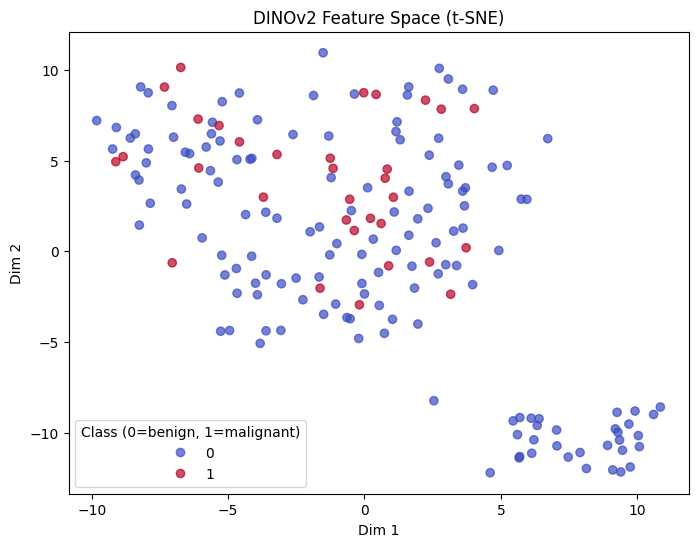

In [43]:
plt.figure(figsize=(8,6))
scatter = plt.scatter(feats_2d[:,0], feats_2d[:,1],c=all_labels, cmap="coolwarm", alpha=0.7)
plt.legend(*scatter.legend_elements(),
           title="Class (0=benign, 1=malignant)")
plt.title("DINOv2 Feature Space (t-SNE)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.show()


In [44]:
plt.savefig("tsne_dino_isic.png", dpi=300, bbox_inches="tight")

<Figure size 640x480 with 0 Axes>

In [45]:
class_names = {0:"benign", 1:"malignant"}


In [46]:
encoder.eval()
classifier.eval()

LinearProbe(
  (fc): Linear(in_features=384, out_features=2, bias=True)
)

In [47]:
imgs, labels = next(iter(test_loader))
imgs = imgs.to(device)
labels = labels.to(device)

In [48]:
with torch.no_grad():
    feats = encoder(imgs)
    logits = classifier(feats)
    preds = torch.argmax(logits, dim=1)

In [49]:
inv_normalize = T.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

In [50]:
imgs_inv = inv_normalize(imgs)

In [ ]:
for i in range(8):
    img = imgs_inv[i].detach().cpu()
    img = img.permute(1, 2, 0)      
    img = img.clamp(0, 1).numpy()
    true_label = class_names[int(labels[i].item())]
    pred_label = class_names[int(preds[i].item())]
    filename = f"sample{i}.png"
    filepath = os.path.join("C:\\Users\\ASUS\\Desktop\\D", filename)
    plt.figure(figsize=(3,3))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"T: {true_label}, P: {pred_label}")
    plt.savefig(filepath, dpi=150, bbox_inches="tight", pad_inches=0.1)
    plt.close()

